#### Introduction: Final Project

#### Group: Josh Forster & Ben Inbar

The final project prompt is fairly open-ended and the main premise of the assignment is to demonstrate a thorough  analysis of a dataset that has network components as well as potential text analysis via NLP methods learned throughout the course. Although these two topic areas diverge in some respect we were able to identify a publicly available Wayfair [dataset](https://github.com/wayfair/WANDS/blob/main/README.md) that lists common product queries on their platform and provides an annotated classificaiton of the result relevancy. In this way, there are several areas that we intend to explore through this workbook:

- 1 Build a bipartite network where nodes are queries and products, and then produce a projection of products, potentially applying a weighting of normalized/factorized label, or average rating, or number of queries.
- 2      Perform PageRank comparison against the provided labels to evaluate the probabilities of a search given a random customer. Further layering in some product information to determine likelihood of certain categories.
- 3      Perform sentiment analysis on the product descriptions provided by the vendors to assess if sentiment correlates with search results positioning, potentially for comparison with customer ratings or number of queries.


#### Load Relevant Libraries

In [89]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import re
import json
import math
import seaborn as sns

In [2]:
labels = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/label.csv'
products = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/product.csv'
queries = 'https://raw.githubusercontent.com/wayfair/WANDS/main/dataset/query.csv'

#### Loading Labeled Dataset

In [10]:
label_df = pd.read_csv(labels,delimiter='\t')
label_df.head()

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


In [12]:
print(label_df.dtypes, label_df.shape)

id             int64
query_id       int64
product_id     int64
label         object
dtype: object (233448, 4)


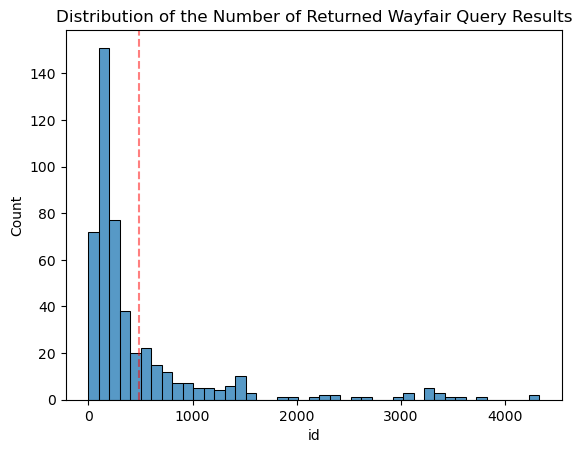

In [58]:
grouped_query_df = label_df.groupby('query_id')['id'].count()
sns.histplot(grouped_query_df).set_title('Distribution of the Number of Returned Wayfair Query Results')
plt.axvline(grouped_query_df.mean(), 0,150,linestyle='--',color='red',alpha=0.5)
plt.show();

The distribution of the query results actually varies quite a bit more than anticipated with a heavy right skew, which would lead to the hypothesis that the terms themselves may have a relationship with the number of results provided. One additional data point to blend in would be the number of terms in the search to see how that impacts the number of results. It is fairly surprising that a query could return over 1000 results, but that likely speaks to the popularity and breadth of certain products. Given the mean count is approximately 500 it would seem as though certain products may have substantial variety in general. On the low end perhaps the searches cannot be clearly inferred, but additional review will need to be conducted.

In [26]:
query_df = pd.read_csv(queries,delimiter='\t')
query_df['number_of_terms'] = query_df['query'].apply(lambda words: len([word for word in words.split()]))
query_df.head()

,query_id,query,query_class,number_of_terms
0,0,salon chair,Massage Chairs,2
1,1,smart coffee table,Coffee & Cocktail Tables,3
2,2,dinosaur,Kids Wall Décor,1
3,3,turquoise pillows,Accent Pillows,2
4,4,chair and a half recliner,Recliners,5


In [29]:
query_df['number_of_terms'].describe()

count    480.000000
mean       3.381250
std        1.495457
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: number_of_terms, dtype: float64

In [27]:
print(query_df.dtypes,query_df.shape)

query_id            int64
query              object
query_class        object
number_of_terms     int64
dtype: object (480, 4)


In [52]:
num_terms = query_df.groupby('number_of_terms')['query'].count().reset_index()
num_terms.rename(columns={'query':'count'},inplace=True)

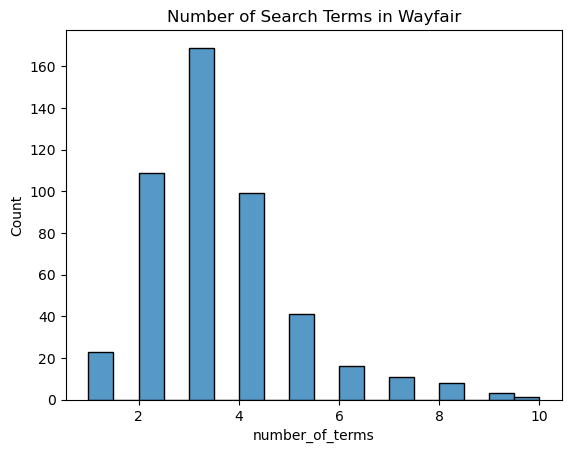

In [56]:
sns.histplot(x='number_of_terms',data=query_df).set_title('Number of Search Terms in Wayfair')
plt.show();

The shape of the dataset appears to be approximately normal aside from a minor skew to the right above 6 terms

In [63]:
label_query_df = pd.merge(label_df,query_df,how='inner',on='query_id')
label_query_df = pd.merge(label_query_df,grouped_query_df,how='inner',left_on='query_id',right_index=True)
label_query_df.rename(columns={'id_y':'number_of_results'},inplace=True)
label_query_df.head()

,id_x,query_id,product_id,label,query,query_class,number_of_terms,number_of_results
0,0,0,25434,Exact,salon chair,Massage Chairs,2,3303
1,1,0,12088,Irrelevant,salon chair,Massage Chairs,2,3303
2,2,0,42931,Exact,salon chair,Massage Chairs,2,3303
3,3,0,2636,Exact,salon chair,Massage Chairs,2,3303
4,4,0,42923,Exact,salon chair,Massage Chairs,2,3303


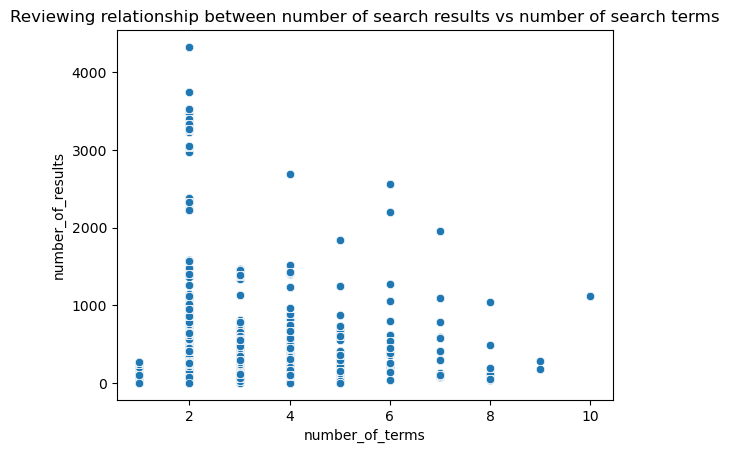

In [66]:
sns.scatterplot(x='number_of_terms',y='number_of_results',data=label_query_df).set_title('Reviewing relationship between number of search results vs number of search terms')
plt.show();

There is not a clear relationship between the number of search terms versus search results as there is possibly a slight negative linear pattern, but it appears there isn't a linear relationship between the two potential features

#### Calculating Pearson Correlation Coefficient
Confirming the visual review of the scatterplot

In [67]:
label_query_df['number_of_terms'].corr(label_query_df['number_of_results'])

-0.3585317151200766

In [68]:
product_df = pd.read_csv(products,delimiter='\t')
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [69]:
(product_df.dtypes,product_df.shape)

(product_id               int64
 product_name            object
 product_class           object
 category hierarchy      object
 product_description     object
 product_features        object
 rating_count           float64
 average_rating         float64
 review_count           float64
 dtype: object,
 (42994, 9))

In [74]:
product_df.describe()

,product_id,rating_count,average_rating,review_count
count,42994.000000,33542.000000,33542.000000,33542.000000
mean,21496.500000,430.270437,4.530126,284.250343
std,12411.443073,2407.921579,0.509263,1539.611737
min,0.000000,1.000000,1.000000,0.000000
25%,10748.250000,8.000000,4.500000,6.000000
50%,21496.500000,42.000000,4.500000,31.000000
75%,32244.750000,195.000000,5.000000,131.000000
max,42993.000000,109226.000000,5.000000,61362.000000


In [75]:
product_df.isnull().sum()

product_id                0
product_name              0
product_class          2852
category hierarchy     1556
product_description    6008
product_features          0
rating_count           9452
average_rating         9452
review_count           9452
dtype: int64

There are some null values in the product dataset that may need to be handled in the network analysis.

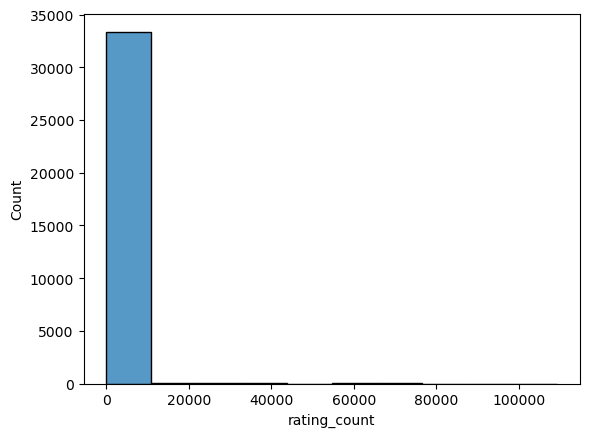

In [73]:
sns.histplot(x='rating_count',data=product_df, bins=10)
plt.show();

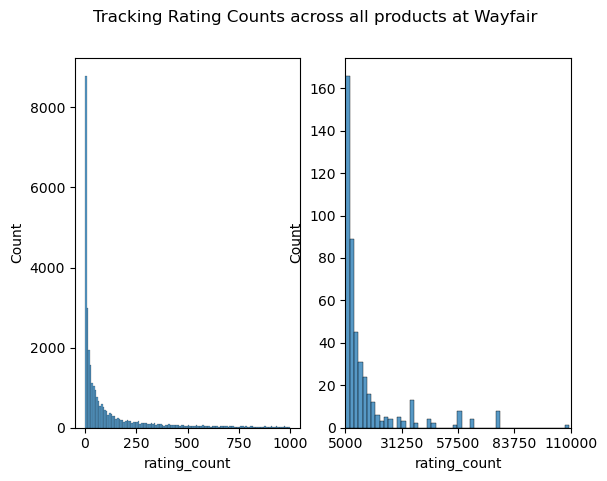

In [94]:
fig, ax = plt.subplots(1,2)
sns.histplot(x='rating_count',data=product_df[product_df['rating_count']<1000], ax=ax[0])
sns.histplot(x='rating_count',data=product_df[product_df['rating_count']>5000], ax=ax[1])
ax[1].set_xlim(5000,110000)
ax[1].set_xticks(np.linspace(5000,110000,5))
fig.suptitle('Tracking Rating Counts across all products at Wayfair')
#sns.histplot(x='rating_count',data=product_df[(product_df['rating_count']>1000)& (product_df['rating_count']>1000)], ax=ax[1])
plt.show();

In [97]:
full_df = pd.merge(label_query_df,product_df,how='inner',on='product_id')
print(full_df.shape)
full_df.head()

(233448, 16)


,id_x,query_id,product_id,label,query,query_class,number_of_terms,number_of_results,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,0,25434,Exact,salon chair,Massage Chairs,2,3303,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
1,68634,26,25434,Exact,leather chairs,Accent Chairs,2,3748,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
2,85371,131,25434,Partial,kids chair,Kids Chairs,2,3479,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
3,90015,151,25434,Partial,leather chair,Accent Chairs,2,3042,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
4,91500,152,25434,Partial,wishbone chair,Dining Chairs,2,3288,21.7 '' w waiting room chair with wood frame,Waiting Room Chairs,Commercial Business Furniture / Commercial Off...,"this is a salon chair , barber chair for a hai...",backupholsterycolor : champagne|primarymateria...,NaN,NaN,NaN
